In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import pyodbc
import sqlalchemy as sqlal
import pandas as pd
import numpy as np

In [136]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        if((user) or (password)):
            print ('Any given username or password will be ignored')
        engine = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        assert user, 'You must define a username'
        assert password, 'You must define a password'
        # For SQL Server authentication
        engine = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    return sqlal.create_engine(engine)

def connect_database(engine):
    try:
        conn = engine.connect()
        print('Connection successfully established')
        return conn
    except Exception as e:
        print(e)

def inspect_engine(engine):
    try:
        insp = sqlal.inspect(engine)
        return insp
    except Exception as e:
        print(e)
    

In [137]:
#engine = sqlal.create_engine('mssql+pyodbc://DESKTOP-JVC9C2F/AdventureWorks2022?driver=SQL Server?Trusted_Connection=yes')
engine= new_engine('mssql+pyodbc','DESKTOP-JVC9C2F','AdventureWorks2022')

In [138]:
connection= connect_database(engine)

Connection successfully established


In [139]:
inspector =inspect_engine(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [140]:
schemas_dataframe= pd.read_sql(sql="SELECT * from SYS.schemas", con=connection)

In [141]:
schemas_dataframe

,name,schema_id,principal_id
0,dbo,1,1
1,guest,2,2
2,INFORMATION_SCHEMA,3,3
3,sys,4,4
4,HumanResources,5,1
5,Person,6,1
6,Production,7,1
7,Purchasing,8,1
8,Sales,9,1
9,db_owner,16384,16384


In [142]:
sales_continent_df = pd.read_sql(sql="""SELECT   b.[Group], sum(SubTotal) as TotPerContinent FROM Sales.SalesOrderHeader as a
INNER JOIN Sales.SalesTerritory as b on a.TerritoryID=b.TerritoryID
GROUP BY b.[Group]""", con= connection)

In [143]:
sales_continent_df

,Group,TotPerContinent
0,Europe,1.983768e+07
1,North America,7.935336e+07
2,Pacific,1.065534e+07


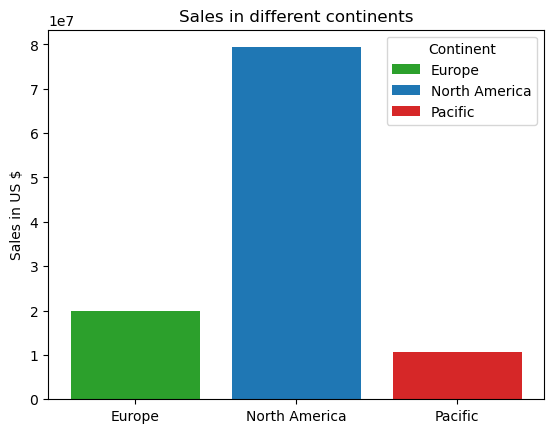

In [144]:
fig, ax = plt.subplots()

continents = sales_continent_df['Group']
sales = sales_continent_df['TotPerContinent']
bar_labels = continents
bar_colors = ['tab:green', 'tab:blue', 'tab:red']

ax.bar(continents, sales, label=bar_labels, color=bar_colors)

ax.set_ylabel('Sales in US $')
ax.set_title('Sales in different continents')
ax.legend(title='Continent')

plt.show()

In [145]:
sales_territory_df = pd.read_sql(sql="""select  a.TerritoryID, b.[Name], sum(Subtotal) as TotPerArea from Sales.SalesOrderHeader as a
inner join Sales.SalesTerritory as b on a.TerritoryID=b.TerritoryID
group by a.territoryID, b.[Name]""",con=connection)

In [146]:
sales_territory_df

,TerritoryID,Name,TotPerArea
0,9,Australia,1.065534e+07
1,3,Central,7.909009e+06
2,6,Canada,1.635577e+07
3,7,France,7.251556e+06
4,1,Northwest,1.608494e+07
5,10,United Kingdom,7.670721e+06
6,4,Southwest,2.418461e+07
7,5,Southeast,7.879655e+06
8,2,Northeast,6.939374e+06
9,8,Germany,4.915408e+06


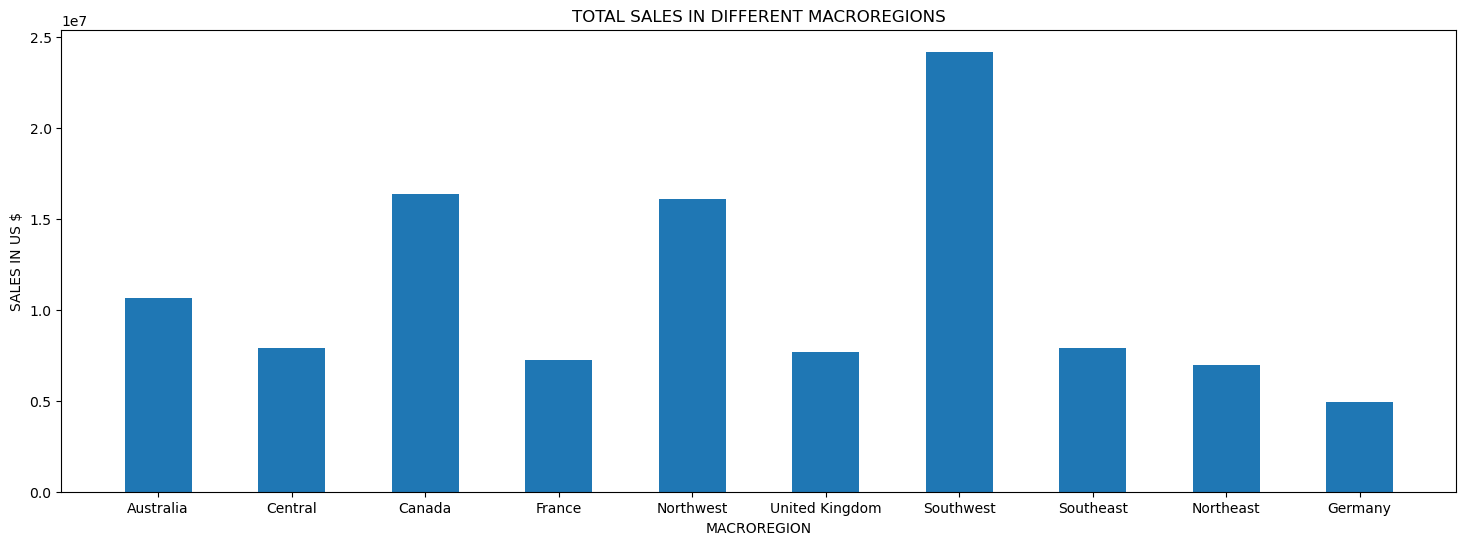

In [147]:
fig, ax = plt.subplots(figsize=(18,6))

territories = sales_territory_df['Name']
sales = sales_territory_df['TotPerArea']
ax.bar(territories, sales, width=0.5)

ax.set_ylabel('SALES IN US $')
ax.set_xlabel('MACROREGION')
ax.set_title('TOTAL SALES IN DIFFERENT MACROREGIONS')



plt.show()

In [148]:
sale_df = pd.read_sql(sql="""Select CustomerID, sum(subTotal) as Purchase
from Sales.SalesOrderHeader
group by CustomerID
order by Purchase desc""", con=connection)

In [149]:
sale_df.head()

,CustomerID,Purchase
0,29818,877107.1923
1,29715,853849.1795
2,29722,841908.7707
3,30117,816755.5763
4,29614,799277.8950


In [150]:
sales=sale_df['Purchase']

In [151]:
sales

0        877107.1923
1        853849.1795
2        841908.7707
3        816755.5763
4        799277.8950
            ...     
19114         2.2900
19115         2.2900
19116         2.2900
19117         2.2900
19118         1.3740
Name: Purchase, Length: 19119, dtype: float64

In [152]:
sales.describe()

count     19119.000000
mean       5745.404122
std       38800.383348
min           1.374000
25%          54.980000
50%         548.980000
75%        2822.386050
max      877107.192300
Name: Purchase, dtype: float64

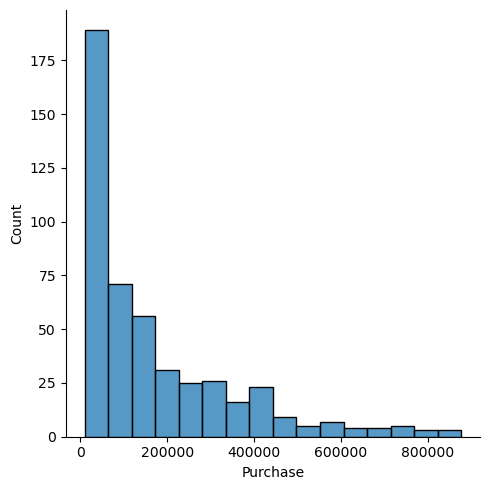

In [158]:
sns.displot(sales[sales>10000])

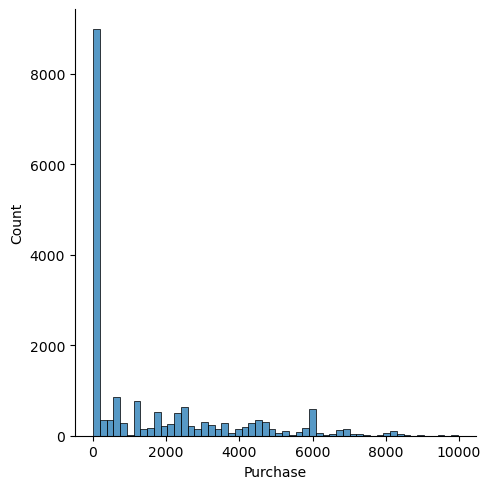

In [155]:
sns.displot(sales[sales<10000])

In [195]:
#most_sold_df = pd.read_sql(sql="""SELECT TOP 20 [Name], a.ProductID, sum(LineTotal) as Tot FROM Production.Product as a
#INNER JOIN Sales.SalesOrderDetail as b on a.ProductID=b.ProductID
#GROUP BY [Name], a.ProductID
#ORDER BY Tot DESC""",con= connection)

In [168]:
#str_list = [str(number) for number in most_sold_df['ProductID']]

In [196]:
#fig, ax = plt.subplots(figsize=(14,4))
#ax.bar(str_list, most_sold_df['Tot'], color= (0.5, 0.8, 0.5, 0.5))
#ax.set_xlabel('Product Id')
#ax.set_ylabel('Total Sales in us $')
#ax.set_title('20 most sold products')
#plt.show()

In [70]:
cte = """with top20sales as (SELECT sum(LineTotal) as Tot,  
    ROW_NUMBER() OVER (ORDER BY sum(LineTotal) desc) AS RowNumber  
    FROM Sales.SalesOrderDetail
	group by ProductID)
	SELECT Tot  
    FROM top20sales 
	where RowNumber = 20"""

In [71]:
r= pd.read_sql(cte,engine)

In [72]:
df_by_sales=pd.read_sql(sql="""
SELECT [Name], a.ProductID, sum(LineTotal) as Tot FROM Production.Product as a
INNER JOIN Sales.SalesOrderDetail as b on a.ProductID=b.ProductID
GROUP BY [Name], a.ProductID
order by ProductID""", con=connection)

In [73]:
df_by_sales.head()

,Name,ProductID,Tot
0,"Sport-100 Helmet, Red",707,157772.394392
1,"Sport-100 Helmet, Black",708,160869.517836
2,"Mountain Bike Socks, M",709,6060.388200
3,"Mountain Bike Socks, L",710,513.000000
4,"Sport-100 Helmet, Blue",711,165406.617049


In [74]:
top20_df= df_by_sales[df_by_sales['Tot']>r['Tot'][0]]

In [75]:
top20_df

,Name,ProductID,Tot
32,"Road-150 Red, 62",749,1.769097e+06
34,"Road-150 Red, 48",751,1.540803e+06
36,"Road-150 Red, 56",753,1.847819e+06
62,"Mountain-200 Silver, 38",779,3.693678e+06
63,"Mountain-200 Silver, 42",780,3.438479e+06
64,"Mountain-200 Silver, 46",781,3.434257e+06
65,"Mountain-200 Black, 38",782,4.400593e+06
66,"Mountain-200 Black, 42",783,4.009495e+06
67,"Mountain-200 Black, 46",784,3.309673e+06
75,"Road-250 Red, 58",792,1.587008e+06


In [175]:
"""x2=[]
   for value in top20_df['ProductID']:
     x2.append(str(value))"""
x2=[str(value) for value in top20_df['ProductID']]

In [176]:
y2=top['Tot']

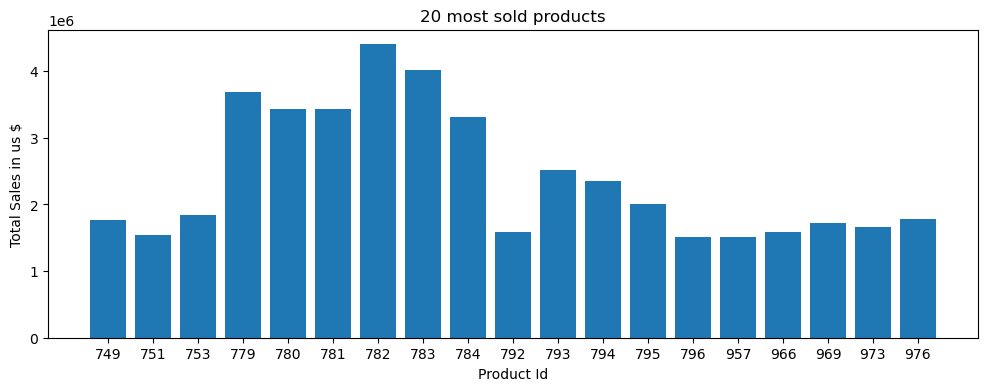

In [192]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(x2,y2)
ax.set_xlabel('Product Id')
ax.set_ylabel('Total Sales in us $')
ax.set_title('20 most sold products')
plt.show()

In [162]:
sales_month_df=pd.read_sql(sql="""SELECT
      concat(month([OrderDate]),'-',year(orderdate)) as Date
      ,sum([SubTotal]) as SalesPerMonth
     
  FROM [AdventureWorks2022].[Sales].[SalesOrderHeader]
  group by year(orderdate),MONTH(OrderDate)
  order by year(orderdate),MONTH(OrderDate)""", con=connection)

In [194]:
sales_month_df

,Date,SalesPerMonth
0,5-2011,5.038059e+05
1,6-2011,4.589108e+05
2,7-2011,2.044600e+06
3,8-2011,2.495817e+06
4,9-2011,5.020738e+05
5,10-2011,4.588762e+06
6,11-2011,7.378398e+05
7,12-2011,1.309863e+06
8,1-2012,3.970627e+06
9,2-2012,1.475427e+06


In [248]:
stringified_date= [str(month) for month in sales_month_df['Date']]

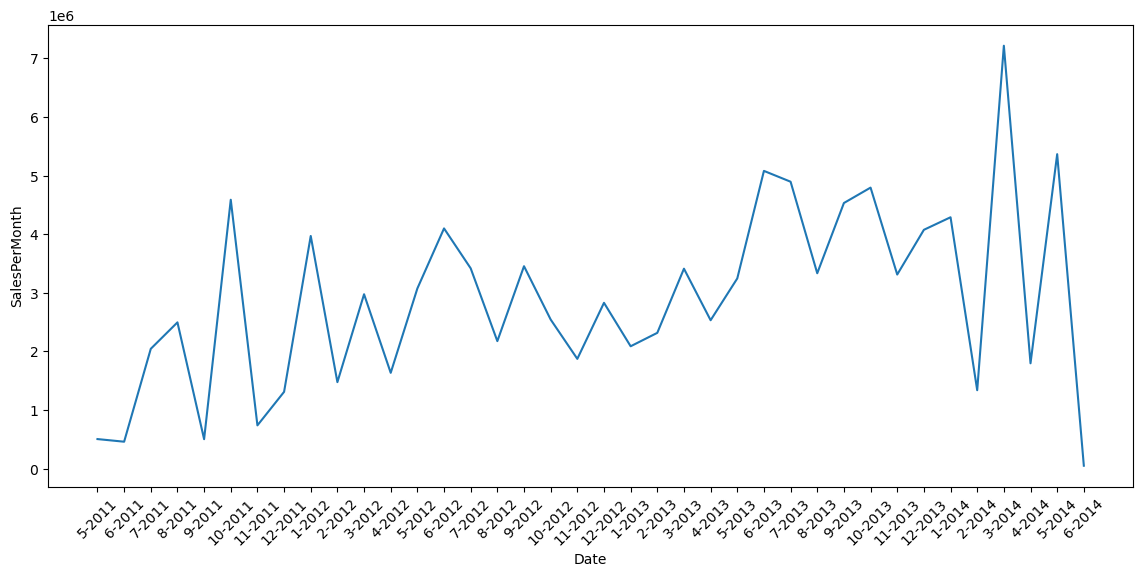

In [250]:
fig, ax = plt.subplots(figsize=(14,6))
sns.lineplot(x=sales_month_df['Date'], y= sales_month_df['SalesPerMonth'], ax=ax)
plt.xticks(rotation=45)
plt.show()

In [254]:
porcoddio = pd.read_sql(sql="""SELECT
      TerritoryID, concat(month(OrderDate),'-',year(OrderDate)) as Date
      ,sum([SubTotal]) as SalesPerMonth
     
  FROM [AdventureWorks2022].[Sales].[SalesOrderHeader]
  GROUP BY TerritoryID,year(OrderDate),MONTH(OrderDate)
  ORDER BY TerritoryID,year(OrderDate),MONTH(OrderDate)
""",con=connection)

In [255]:
porcoddio.head()

,TerritoryID,Date,SalesPerMonth
0,1,5-2011,97305.5951
1,1,6-2011,55186.5046
2,1,7-2011,340025.5667
3,1,8-2011,443293.6769
4,1,9-2011,58968.0546


In [256]:
porcoddio.index= porcoddio['Date']


In [262]:
porcoddio

,TerritoryID,Date,SalesPerMonth
Date,,,
5-2011,1,5-2011,97305.5951
6-2011,1,6-2011,55186.5046
7-2011,1,7-2011,340025.5667
8-2011,1,8-2011,443293.6769
9-2011,1,9-2011,58968.0546
...,...,...,...
2-2014,10,2-2014,175784.4000
3-2014,10,3-2014,496686.0266
4-2014,10,4-2014,206451.5100


In [260]:
aaa

Index(['5-2011', '6-2011', '7-2011', '8-2011', '9-2011', '10-2011', '11-2011',
       '12-2011', '1-2012', '2-2012',
       ...
       '9-2013', '10-2013', '11-2013', '12-2013', '1-2014', '2-2014', '3-2014',
       '4-2014', '5-2014', '6-2014'],
      dtype='object', name='Date', length=364)

In [261]:

porco = porcoddio.pivot(index=aaa, columns="TerritoryID",values="SalesPerMonth",)
porco.head()

KeyError: '5-2011'

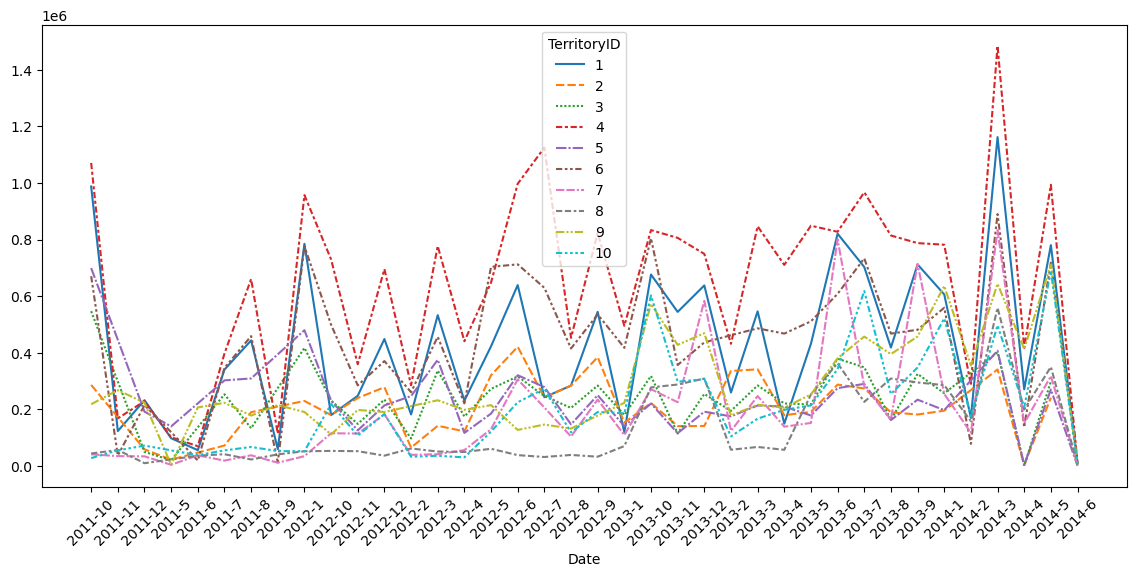

In [237]:
fig, ax = plt.subplots(figsize=(14,6))
sns.lineplot(data=porco,ax=ax)
plt.xticks(rotation=45)
plt.show()

In [217]:
data=porcoddio[porcoddio['TerritoryID']==2]

In [218]:
data

,TerritoryID,Date,SalesPerMonth
38,2,5-2011,21598.3855
39,2,7-2011,71552.8892
40,2,8-2011,189511.8523
41,2,10-2011,285882.3884
42,2,12-2011,58080.1765
43,2,1-2012,229138.6140
44,2,2-2012,64187.8415
45,2,3-2012,141299.6699
46,2,4-2012,121668.6528
47,2,5-2012,320044.8497
